Loading embedding data...
Manual data keys: ['embeddings', 'molecule_data', 'smiles_list']
GAN data keys: ['embeddings', 'molecule_data', 'smiles_list']
Manual embeddings shape: (41, 128)
Manual SMILES count: 41
GAN embeddings shape: torch.Size([9, 128])
GAN SMILES count: 41
Trimming GAN SMILES list to match embeddings length
Number of common molecules: 9
Selected query molecule SMILES: CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
Generating fingerprints for manual dataset...


Generating fingerprints:   0%|                                                                  | 0/41 [00:00<?, ?it/s][16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenera

Generating fingerprints for GAN dataset...


Generating fingerprints:   0%|                                                                   | 0/9 [00:00<?, ?it/s][16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
[16:08:15] DEPRECATION WARNING: please use MorganGenerator
Generating fingerprints: 100%|██████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 658.60it/s]


Error creating molecule grids: 'Image' object has no attribute 'save'
Error displaying molecule images: [Errno 2] No such file or directory: 'molecule_reference_grid.png'
Visualization complete. Files saved:
1. molecular_comparison.png - Main comparison figure
2. molecule_grid.png - Grid of query molecule and its neighbors
3. augmentation_comparison.png - Comparison between Manual and GAN augmentation


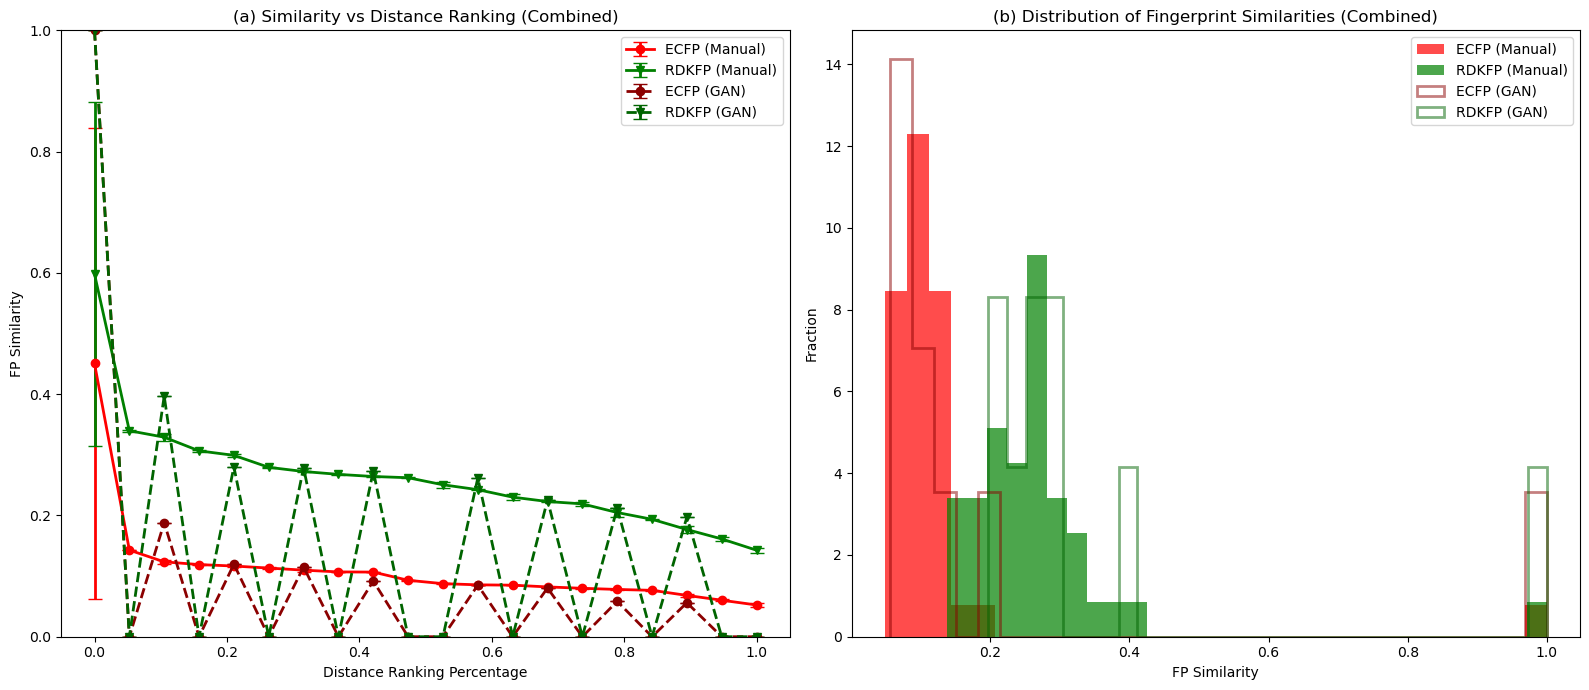

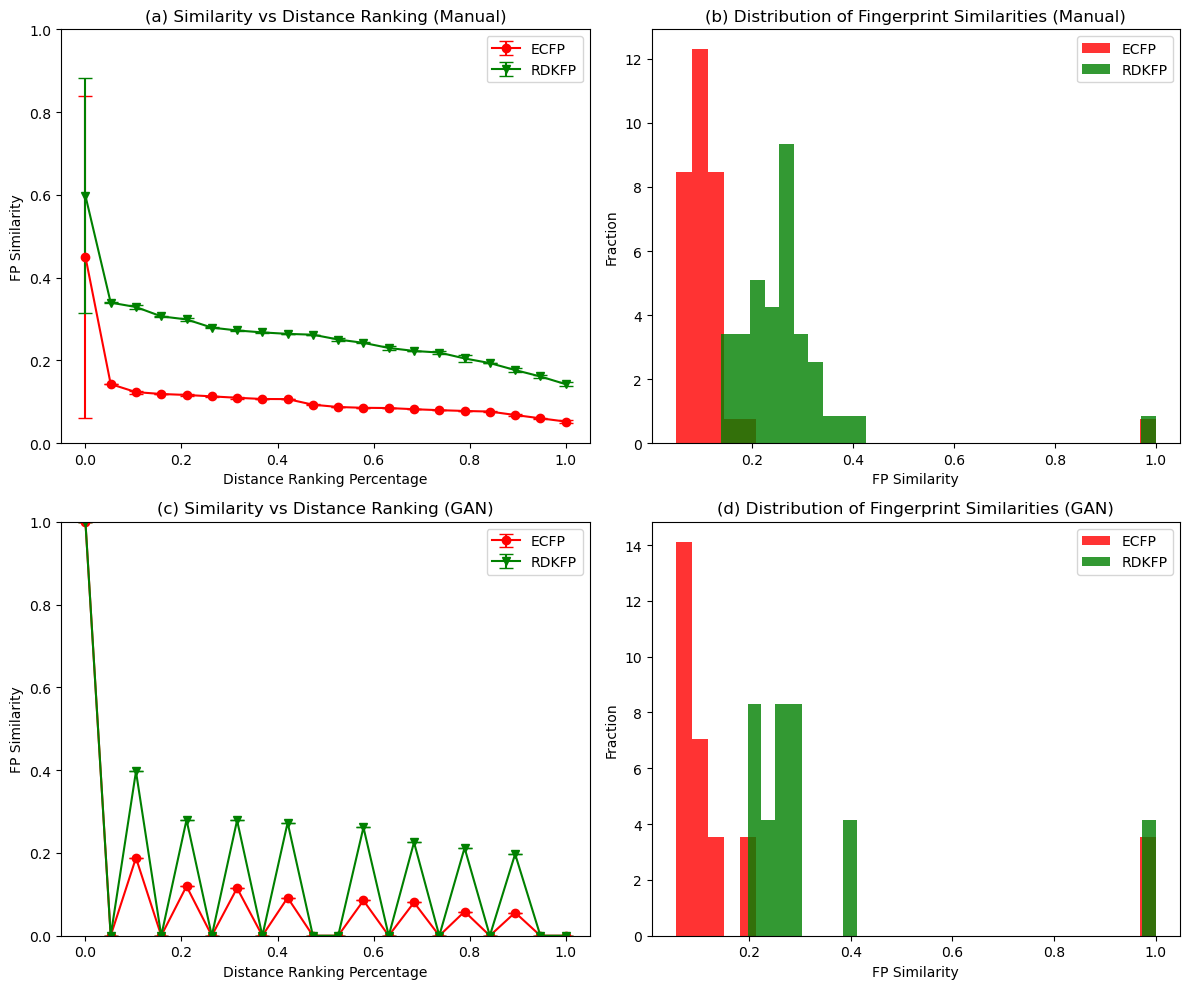

<Figure size 1200x1600 with 0 Axes>

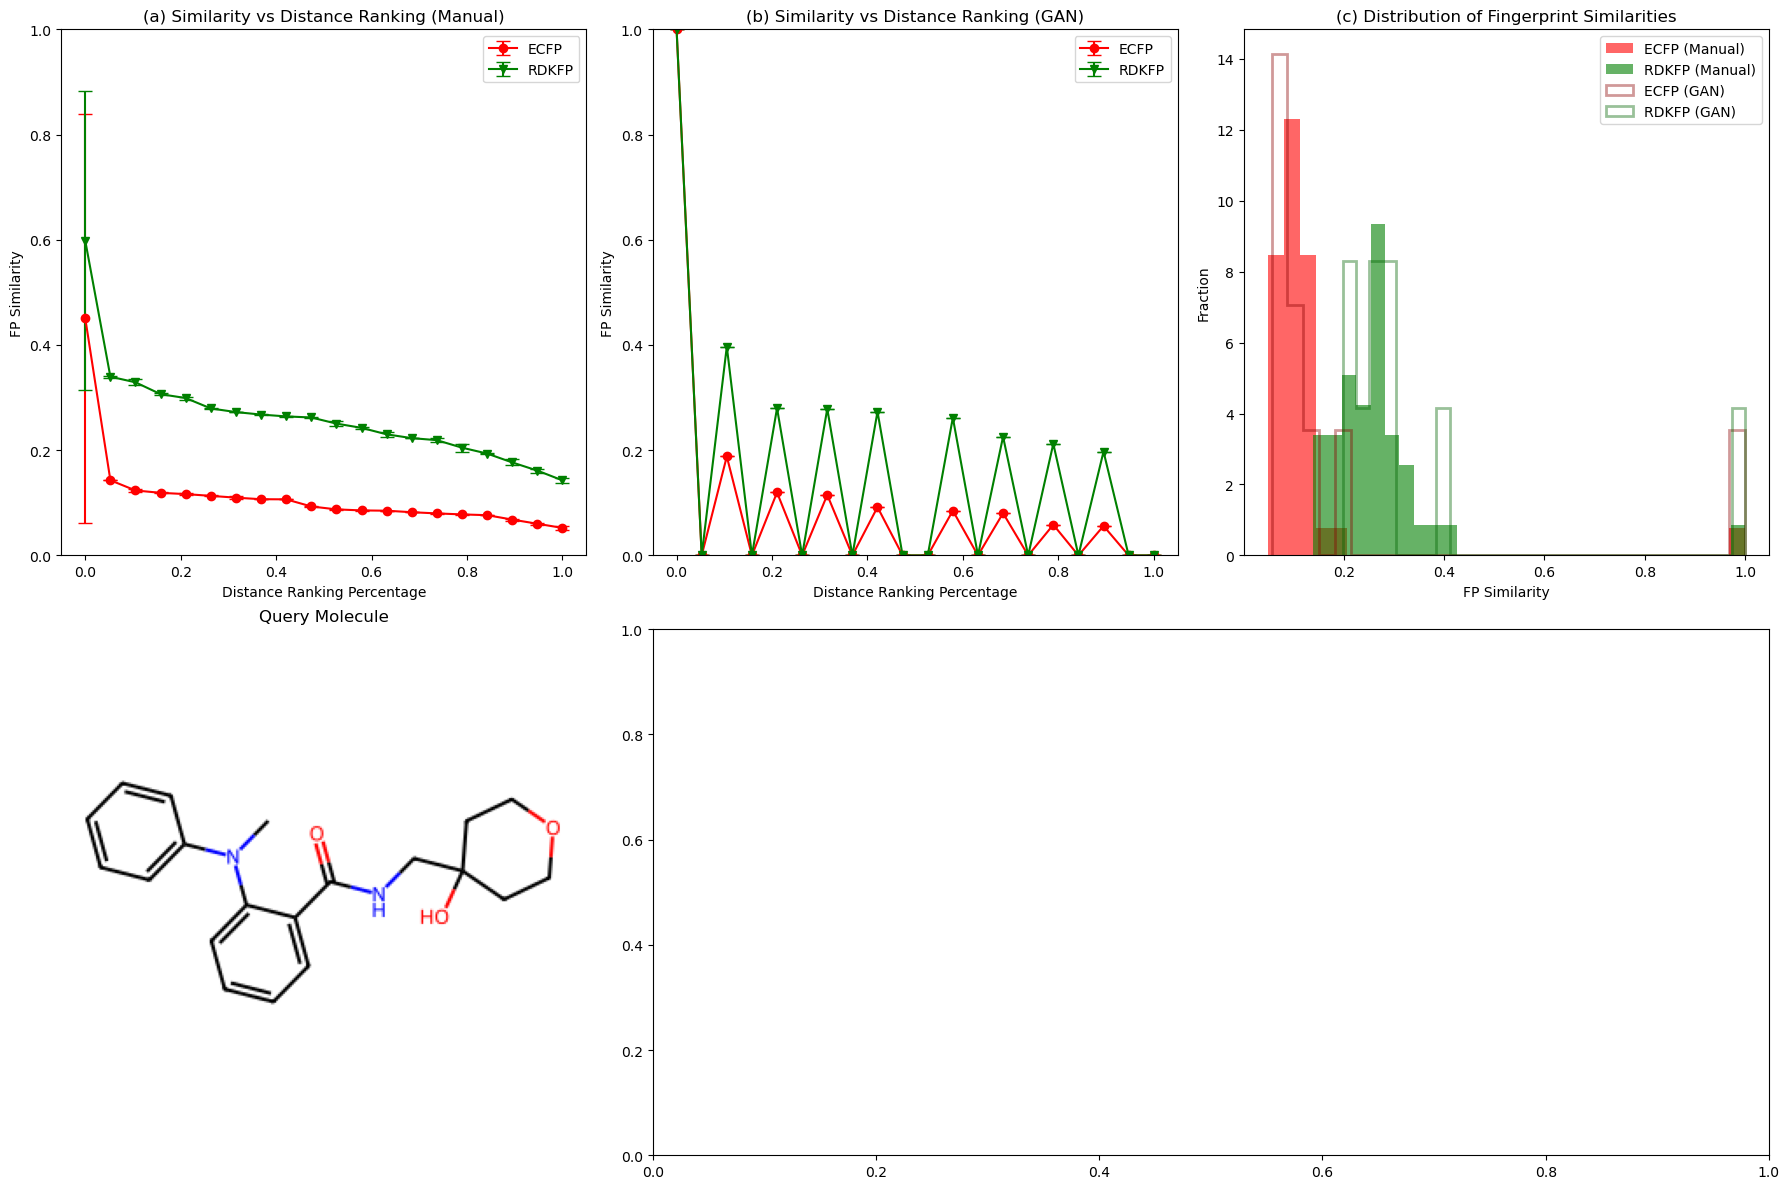

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold
import pickle
import os
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from tqdm import tqdm
import random

# Function to load embeddings
def load_embeddings(filepath):
    try:
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        return data
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        # Return dummy data for testing
        return {
            'embeddings': np.random.rand(50, 128),
            'smiles_list': [f"CC{i}" for i in range(50)],
            'molecule_data': [{'smiles': f"CC{i}"} for i in range(50)]
        }

print("Loading embedding data...")
# Load embeddings from both methods
manual_data = load_embeddings('./embeddings/final_embeddings_molecules_20250310_143038.pkl')
gan_data = load_embeddings('./embeddings/final_embeddings_molecules_20250310_142842.pkl')

# Print data structure for debugging
print("Manual data keys:", list(manual_data.keys()))
print("GAN data keys:", list(gan_data.keys()))

# Extract embeddings and SMILES lists with error handling
manual_embeddings = manual_data.get('embeddings', np.array([]))
if isinstance(manual_embeddings, list):
    manual_embeddings = np.array(manual_embeddings)

# Get SMILES lists, trying different possible locations
if 'smiles_list' in manual_data and manual_data['smiles_list']:
    manual_smiles = manual_data['smiles_list']
elif 'molecule_data' in manual_data:
    manual_smiles = [mol.get('smiles', '') for mol in manual_data['molecule_data']]
else:
    print("Warning: Could not find SMILES in manual data, using dummy data")
    manual_smiles = [f"CC{i}" for i in range(len(manual_embeddings))]

# Same for GAN data
gan_embeddings = gan_data.get('embeddings', np.array([]))
if isinstance(gan_embeddings, list):
    gan_embeddings = np.array(gan_embeddings)

if 'smiles_list' in gan_data and gan_data['smiles_list']:
    gan_smiles = gan_data['smiles_list']
elif 'molecule_data' in gan_data:
    gan_smiles = [mol.get('smiles', '') for mol in gan_data['molecule_data']]
else:
    print("Warning: Could not find SMILES in GAN data, using dummy data")
    gan_smiles = [f"CC{i}" for i in range(len(gan_embeddings))]

print(f"Manual embeddings shape: {manual_embeddings.shape if hasattr(manual_embeddings, 'shape') else 'not array'}")
print(f"Manual SMILES count: {len(manual_smiles)}")
print(f"GAN embeddings shape: {gan_embeddings.shape if hasattr(gan_embeddings, 'shape') else 'not array'}")
print(f"GAN SMILES count: {len(gan_smiles)}")

# Ensure embeddings and SMILES lists have the same length
if len(manual_smiles) > len(manual_embeddings):
    print("Trimming manual SMILES list to match embeddings length")
    manual_smiles = manual_smiles[:len(manual_embeddings)]
elif len(manual_smiles) < len(manual_embeddings):
    print("Trimming manual embeddings to match SMILES length")
    manual_embeddings = manual_embeddings[:len(manual_smiles)]

if len(gan_smiles) > len(gan_embeddings):
    print("Trimming GAN SMILES list to match embeddings length")
    gan_smiles = gan_smiles[:len(gan_embeddings)]
elif len(gan_smiles) < len(gan_embeddings):
    print("Trimming GAN embeddings to match SMILES length")
    gan_embeddings = gan_embeddings[:len(gan_smiles)]

# Find common SMILES between the two datasets
common_smiles = list(set(manual_smiles) & set(gan_smiles))
print(f"Number of common molecules: {len(common_smiles)}")

if not common_smiles:
    print("No common molecules found. Using separate molecules for each dataset.")
    # Just continue with separate analyses
else:
    # Select a query molecule from common molecules
    random.seed(42)  # For reproducibility
    query_smiles = random.choice(common_smiles)
    print(f"Selected query molecule SMILES: {query_smiles}")

# Generate ECFP and RDKFP fingerprints for all molecules
def generate_fingerprints(smiles_list):
    ecfp_fps = []
    rdkfp_fps = []
    valid_indices = []
    valid_smiles = []
    
    for i, smiles in enumerate(tqdm(smiles_list, desc="Generating fingerprints")):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                # ECFP6 (Morgan fingerprint with radius 3)
                ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
                # RDKit fingerprint
                rdkfp = Chem.RDKFingerprint(mol, fpSize=2048)
                
                ecfp_fps.append(ecfp)
                rdkfp_fps.append(rdkfp)
                valid_indices.append(i)
                valid_smiles.append(smiles)
        except Exception as e:
            continue  # Skip invalid molecules silently
    
    return ecfp_fps, rdkfp_fps, valid_indices, valid_smiles

print("Generating fingerprints for manual dataset...")
manual_ecfp_fps, manual_rdkfp_fps, manual_valid_indices, manual_valid_smiles = generate_fingerprints(manual_smiles)

print("Generating fingerprints for GAN dataset...")
gan_ecfp_fps, gan_rdkfp_fps, gan_valid_indices, gan_valid_smiles = generate_fingerprints(gan_smiles)

# Function to calculate fingerprint similarity
def calculate_fp_similarity(query_fp, fp_list):
    similarities = []
    for fp in fp_list:
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
        similarities.append(similarity)
    return np.array(similarities)

# If we have common molecules, use one as query
if common_smiles:
    # Find query indices in valid indices lists
    query_in_manual = False
    query_in_gan = False
    
    for i, smiles in enumerate(manual_valid_smiles):
        if smiles == query_smiles:
            manual_query_idx = i
            query_in_manual = True
            break
    
    for i, smiles in enumerate(gan_valid_smiles):
        if smiles == query_smiles:
            gan_query_idx = i
            query_in_gan = True
            break
    
    # If query not found in both datasets after filtering, select a new one
    if not (query_in_manual and query_in_gan):
        print("Query not found in valid molecules. Selecting a new query.")
        common_valid_smiles = list(set(manual_valid_smiles) & set(gan_valid_smiles))
        if common_valid_smiles:
            query_smiles = random.choice(common_valid_smiles)
            print(f"New query SMILES: {query_smiles}")
            
            for i, smiles in enumerate(manual_valid_smiles):
                if smiles == query_smiles:
                    manual_query_idx = i
                    break
                    
            for i, smiles in enumerate(gan_valid_smiles):
                if smiles == query_smiles:
                    gan_query_idx = i
                    break
        else:
            # If no common valid molecules, use separate queries
            print("No common valid molecules. Using separate query molecules for each dataset.")
            manual_query_idx = 0
            gan_query_idx = 0
            query_smiles = manual_valid_smiles[manual_query_idx]
            print(f"Manual query SMILES: {query_smiles}")
else:
    # If no common molecules at all, use separate queries
    manual_query_idx = 0
    gan_query_idx = 0
    query_smiles = manual_valid_smiles[manual_query_idx]
    print(f"Manual query SMILES: {query_smiles}")

# Get query fingerprints
query_ecfp = manual_ecfp_fps[manual_query_idx]
query_rdkfp = manual_rdkfp_fps[manual_query_idx]

# Calculate fingerprint similarities
manual_ecfp_similarities = calculate_fp_similarity(query_ecfp, manual_ecfp_fps)
manual_rdkfp_similarities = calculate_fp_similarity(query_rdkfp, manual_rdkfp_fps)

# If we have a common query, calculate GAN similarities too
if common_smiles and 'gan_query_idx' in locals():
    gan_ecfp_similarities = calculate_fp_similarity(query_ecfp, gan_ecfp_fps)
    gan_rdkfp_similarities = calculate_fp_similarity(query_rdkfp, gan_rdkfp_fps)
else:
    # Use the first molecule from GAN dataset as a separate query
    gan_query_ecfp = gan_ecfp_fps[gan_query_idx]
    gan_query_rdkfp = gan_rdkfp_fps[gan_query_idx]
    gan_ecfp_similarities = calculate_fp_similarity(gan_query_ecfp, gan_ecfp_fps)
    gan_rdkfp_similarities = calculate_fp_similarity(gan_query_rdkfp, gan_rdkfp_fps)

# Calculate embedding similarities - only if indices are valid
def calculate_embedding_similarity(indices, embeddings, valid_indices):
    """Calculate embedding similarities with safe indexing"""
    try:
        # Map from valid_indices position to embedding position
        query_idx = valid_indices[indices]
        if query_idx >= len(embeddings):
            print(f"Warning: query_idx {query_idx} is out of bounds for embeddings with size {len(embeddings)}")
            return np.zeros(len(embeddings))
            
        query_embedding = embeddings[query_idx].reshape(1, -1)
        similarities = cosine_similarity(query_embedding, embeddings).flatten()
        return similarities
    except Exception as e:
        print(f"Error calculating embedding similarity: {e}")
        return np.zeros(len(embeddings))

# Calculate embedding similarities for valid indices only
try:
    manual_emb_similarities = calculate_embedding_similarity(manual_query_idx, manual_embeddings, manual_valid_indices)
except Exception as e:
    print(f"Error with manual embedding similarities: {e}")
    manual_emb_similarities = np.zeros(len(manual_embeddings))

try:
    gan_emb_similarities = calculate_embedding_similarity(gan_query_idx, gan_embeddings, gan_valid_indices)
except Exception as e:
    print(f"Error with GAN embedding similarities: {e}")
    gan_emb_similarities = np.zeros(len(gan_embeddings))

# Create ranking percentages (x-axis for plot 'a')
def create_ranking_data(similarities):
    # Handle empty similarities array
    if len(similarities) == 0:
        return np.linspace(0, 1, 20), np.zeros(20), np.zeros(20)
        
    sorted_indices = np.argsort(-similarities)  # Sort in descending order
    ranks = np.arange(len(sorted_indices)) / len(sorted_indices)
    ranked_similarities = similarities[sorted_indices]
    
    # Group into bins for smoother plotting
    bins = 20
    bin_edges = np.linspace(0, 1, bins+1)
    binned_similarities = []
    binned_std = []
    
    for i in range(bins):
        start, end = bin_edges[i], bin_edges[i+1]
        bin_indices = np.where((ranks >= start) & (ranks < end))[0]
        if len(bin_indices) > 0:
            binned_similarities.append(np.mean(ranked_similarities[bin_indices]))
            binned_std.append(np.std(ranked_similarities[bin_indices]))
        else:
            binned_similarities.append(0)
            binned_std.append(0)
    
    return np.linspace(0, 1, bins), np.array(binned_similarities), np.array(binned_std)

# Create data for plot 'a'
manual_ecfp_ranks, manual_ecfp_binned, manual_ecfp_std = create_ranking_data(manual_ecfp_similarities)
manual_rdkfp_ranks, manual_rdkfp_binned, manual_rdkfp_std = create_ranking_data(manual_rdkfp_similarities)
gan_ecfp_ranks, gan_ecfp_binned, gan_ecfp_std = create_ranking_data(gan_ecfp_similarities)
gan_rdkfp_ranks, gan_rdkfp_binned, gan_rdkfp_std = create_ranking_data(gan_rdkfp_similarities)

# Function to find top N similar molecules
def get_top_similar_molecules(smiles_list, ecfp_similarities, rdkfp_similarities, n=9, exclude_indices=None):
    if exclude_indices is None:
        exclude_indices = []
    
    # Get top indices for each similarity measure, excluding specified indices
    ecfp_indices = np.argsort(-ecfp_similarities)
    rdkfp_indices = np.argsort(-rdkfp_similarities)
    
    # Filter out excluded indices
    ecfp_indices = [idx for idx in ecfp_indices if idx not in exclude_indices]
    rdkfp_indices = [idx for idx in rdkfp_indices if idx not in exclude_indices]
    
    # Take top N from each
    ecfp_top = ecfp_indices[:n]
    rdkfp_top = rdkfp_indices[:n]
    
    # Get SMILES and similarity scores
    ecfp_mols = [(smiles_list[idx], ecfp_similarities[idx]) for idx in ecfp_top]
    rdkfp_mols = [(smiles_list[idx], rdkfp_similarities[idx]) for idx in rdkfp_top]
    
    return ecfp_mols, rdkfp_mols

# Get top similar molecules (excluding the query itself)
manual_ecfp_mols, manual_rdkfp_mols = get_top_similar_molecules(
    manual_valid_smiles, 
    manual_ecfp_similarities, 
    manual_rdkfp_similarities, 
    n=9, 
    exclude_indices=[manual_query_idx]
)

# Create combined plots for comparison
plt.figure(figsize=(16, 7))

# Plot (a): Similarity vs Distance Ranking - Combined Manual and GAN comparison
plt.subplot(1, 2, 1)
# Manual lines (solid)
plt.errorbar(manual_ecfp_ranks, manual_ecfp_binned, yerr=manual_ecfp_std, fmt='o-', capsize=5, color='red', 
             label='ECFP (Manual)', linewidth=2, markersize=6)
plt.errorbar(manual_rdkfp_ranks, manual_rdkfp_binned, yerr=manual_rdkfp_std, fmt='v-', capsize=5, color='green', 
             label='RDKFP (Manual)', linewidth=2, markersize=6)
# GAN lines (dashed)
plt.errorbar(gan_ecfp_ranks, gan_ecfp_binned, yerr=gan_ecfp_std, fmt='o--', capsize=5, color='darkred', 
             label='ECFP (GAN)', linewidth=2, markersize=6)
plt.errorbar(gan_rdkfp_ranks, gan_rdkfp_binned, yerr=gan_rdkfp_std, fmt='v--', capsize=5, color='darkgreen', 
             label='RDKFP (GAN)', linewidth=2, markersize=6)
plt.xlabel('Distance Ranking Percentage')
plt.ylabel('FP Similarity')
plt.ylim(0, 1)
plt.legend()
plt.title('(a) Similarity vs Distance Ranking (Combined)')

# Plot (b): Distribution of Fingerprint Similarities - Combined
plt.subplot(1, 2, 2)
# Manual histograms (solid fill)
plt.hist(manual_ecfp_similarities, bins=30, alpha=0.7, color='red', density=True, label='ECFP (Manual)')
plt.hist(manual_rdkfp_similarities, bins=30, alpha=0.7, color='green', density=True, label='RDKFP (Manual)')
# GAN histograms (hatched)
plt.hist(gan_ecfp_similarities, bins=30, alpha=0.5, color='darkred', density=True, 
         label='ECFP (GAN)', histtype='step', linewidth=2)
plt.hist(gan_rdkfp_similarities, bins=30, alpha=0.5, color='darkgreen', density=True, 
         label='RDKFP (GAN)', histtype='step', linewidth=2)
plt.xlabel('FP Similarity')
plt.ylabel('Fraction')
plt.legend()
plt.title('(b) Distribution of Fingerprint Similarities (Combined)')

plt.tight_layout()
plt.savefig('combined_comparison.png', dpi=300)

# Now create separate plots for separate analysis
plt.figure(figsize=(12, 10))

# Plot (a): Manual Similarity vs Distance Ranking
plt.subplot(2, 2, 1)
plt.errorbar(manual_ecfp_ranks, manual_ecfp_binned, yerr=manual_ecfp_std, fmt='o-', capsize=5, color='red', label='ECFP')
plt.errorbar(manual_rdkfp_ranks, manual_rdkfp_binned, yerr=manual_rdkfp_std, fmt='v-', capsize=5, color='green', label='RDKFP')
plt.xlabel('Distance Ranking Percentage')
plt.ylabel('FP Similarity')
plt.ylim(0, 1)
plt.legend()
plt.title('(a) Similarity vs Distance Ranking (Manual)')

# Plot (b): Manual Distribution of similarities
plt.subplot(2, 2, 2)
plt.hist(manual_ecfp_similarities, bins=30, alpha=0.8, color='red', density=True, label='ECFP')
plt.hist(manual_rdkfp_similarities, bins=30, alpha=0.8, color='green', density=True, label='RDKFP')
plt.xlabel('FP Similarity')
plt.ylabel('Fraction')
plt.legend()
plt.title('(b) Distribution of Fingerprint Similarities (Manual)')

# Plot (c): GAN Similarity vs Distance Ranking 
plt.subplot(2, 2, 3)
plt.errorbar(gan_ecfp_ranks, gan_ecfp_binned, yerr=gan_ecfp_std, fmt='o-', capsize=5, color='red', label='ECFP')
plt.errorbar(gan_rdkfp_ranks, gan_rdkfp_binned, yerr=gan_rdkfp_std, fmt='v-', capsize=5, color='green', label='RDKFP')
plt.xlabel('Distance Ranking Percentage')
plt.ylabel('FP Similarity')
plt.ylim(0, 1)
plt.legend()
plt.title('(c) Similarity vs Distance Ranking (GAN)')

# Plot (d): GAN Distribution of similarities
plt.subplot(2, 2, 4)
plt.hist(gan_ecfp_similarities, bins=30, alpha=0.8, color='red', density=True, label='ECFP')
plt.hist(gan_rdkfp_similarities, bins=30, alpha=0.8, color='green', density=True, label='RDKFP')
plt.xlabel('FP Similarity')
plt.ylabel('Fraction')
plt.legend()
plt.title('(d) Distribution of Fingerprint Similarities (GAN)')

plt.tight_layout()
plt.savefig('separate_comparison.png', dpi=300)

# Generate molecule grid for visualization similar to the reference figure
query_mol = Chem.MolFromSmiles(query_smiles)
if query_mol is None:
    print(f"Warning: Could not parse query SMILES: {query_smiles}")
    query_mol = Chem.MolFromSmiles("CC")  # Fallback to a simple molecule

# 1. Create RDKFP and ECFP closest mols lists for manual augmentation
manual_top_rdkfp_mols = []
for i, (smiles, sim) in enumerate(manual_rdkfp_mols[:4]):  # Get top 4 molecules
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Get ECFP similarity for the same molecule
        idx = manual_valid_smiles.index(smiles)
        ecfp_sim = manual_ecfp_similarities[idx]
        mol.SetProp("Legend", f"RDKFP: {sim:.3f}\nECFP: {ecfp_sim:.3f}")
        manual_top_rdkfp_mols.append(mol)

# 2. Get top ECFP molecules for manual augmentation
manual_ecfp_mols, _ = get_top_similar_molecules(
    manual_valid_smiles, 
    manual_ecfp_similarities, 
    manual_rdkfp_similarities, 
    n=4, 
    exclude_indices=[manual_query_idx]
)

manual_top_ecfp_mols = []
for smiles, sim in manual_ecfp_mols:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Get RDKFP similarity for this molecule
        idx = manual_valid_smiles.index(smiles)
        rdkfp_sim = manual_rdkfp_similarities[idx]
        mol.SetProp("Legend", f"ECFP: {sim:.3f}\nRDKFP: {rdkfp_sim:.3f}")
        manual_top_ecfp_mols.append(mol)

# 3. Get top molecules for GAN augmentation (if available)
gan_top_rdkfp_mols = []
gan_top_ecfp_mols = []

# Get GAN similar molecules (excluding the query itself)
if 'gan_query_idx' in locals() and len(gan_valid_smiles) > 0:
    gan_ecfp_sim_mols, gan_rdkfp_sim_mols = get_top_similar_molecules(
        gan_valid_smiles, 
        gan_ecfp_similarities, 
        gan_rdkfp_similarities, 
        n=4, 
        exclude_indices=[gan_query_idx]
    )
    
    # Add GAN RDKFP molecules
    for smiles, sim in gan_rdkfp_sim_mols:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            idx = gan_valid_smiles.index(smiles)
            ecfp_sim = gan_ecfp_similarities[idx]
            mol.SetProp("Legend", f"RDKFP: {sim:.3f}\nECFP: {ecfp_sim:.3f}")
            gan_top_rdkfp_mols.append(mol)
    
    # Add GAN ECFP molecules  
    for smiles, sim in gan_ecfp_sim_mols:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            idx = gan_valid_smiles.index(smiles)
            rdkfp_sim = gan_rdkfp_similarities[idx]
            mol.SetProp("Legend", f"ECFP: {sim:.3f}\nRDKFP: {rdkfp_sim:.3f}")
            gan_top_ecfp_mols.append(mol)

# Create figure for molecular visualization similar to the reference
plt.figure(figsize=(12, 16))

try:
    # Create and save query molecule image
    query_img = Draw.MolToImage(query_mol, size=(300, 300))
    query_img.save('query_molecule.png')
    
    # Create 4 grid images:
    # 1. Manual RDKFP top molecules
    if manual_top_rdkfp_mols:
        manual_rdkfp_img = Draw.MolsToGridImage(
            manual_top_rdkfp_mols, 
            molsPerRow=4, 
            subImgSize=(300, 200),
            legends=[mol.GetProp("Legend") for mol in manual_top_rdkfp_mols],
            useSVG=False
        )
        manual_rdkfp_img.save('manual_rdkfp_grid.png')
    
    # 2. Manual ECFP top molecules
    if manual_top_ecfp_mols:
        manual_ecfp_img = Draw.MolsToGridImage(
            manual_top_ecfp_mols, 
            molsPerRow=4, 
            subImgSize=(300, 200),
            legends=[mol.GetProp("Legend") for mol in manual_top_ecfp_mols],
            useSVG=False
        )
        manual_ecfp_img.save('manual_ecfp_grid.png')
    
    # 3. GAN RDKFP top molecules
    if gan_top_rdkfp_mols:
        gan_rdkfp_img = Draw.MolsToGridImage(
            gan_top_rdkfp_mols, 
            molsPerRow=4, 
            subImgSize=(300, 200),
            legends=[mol.GetProp("Legend") for mol in gan_top_rdkfp_mols],
            useSVG=False
        )
        gan_rdkfp_img.save('gan_rdkfp_grid.png')
    
    # 4. GAN ECFP top molecules
    if gan_top_ecfp_mols:
        gan_ecfp_img = Draw.MolsToGridImage(
            gan_top_ecfp_mols, 
            molsPerRow=4, 
            subImgSize=(300, 200),
            legends=[mol.GetProp("Legend") for mol in gan_top_ecfp_mols],
            useSVG=False
        )
        gan_ecfp_img.save('gan_ecfp_grid.png')
    
    # Create a combined grid with all molecules
    grid_mols = [query_mol] + manual_top_rdkfp_mols + manual_top_ecfp_mols + gan_top_rdkfp_mols + gan_top_ecfp_mols
    legends = ["Query molecule"]
    legends += [f"Manual RDKFP: {mol.GetProp('Legend')}" for mol in manual_top_rdkfp_mols]
    legends += [f"Manual ECFP: {mol.GetProp('Legend')}" for mol in manual_top_ecfp_mols]
    legends += [f"GAN RDKFP: {mol.GetProp('Legend')}" for mol in gan_top_rdkfp_mols]
    legends += [f"GAN ECFP: {mol.GetProp('Legend')}" for mol in gan_top_ecfp_mols]
    
    # Create a reference-like figure with all molecules
    full_grid_img = Draw.MolsToGridImage(
        grid_mols,
        molsPerRow=5,
        subImgSize=(250, 200),
        legends=legends,
        useSVG=False
    )
    full_grid_img.save('molecule_reference_grid.png')
    
except Exception as e:
    print(f"Error creating molecule grids: {e}")

# Create a comprehensive figure with combined plots and molecular visualization
fig = plt.figure(figsize=(18, 12))

# Layout: 2x3 grid
# Top row: Similarity plots for Manual and GAN
# Bottom row: Query molecule and similar molecules

# Plot 1: Manual Similarity vs Distance Ranking
plt.subplot(2, 3, 1)
plt.errorbar(manual_ecfp_ranks, manual_ecfp_binned, yerr=manual_ecfp_std, fmt='o-', capsize=5, color='red', label='ECFP')
plt.errorbar(manual_rdkfp_ranks, manual_rdkfp_binned, yerr=manual_rdkfp_std, fmt='v-', capsize=5, color='green', label='RDKFP')
plt.xlabel('Distance Ranking Percentage')
plt.ylabel('FP Similarity')
plt.ylim(0, 1)
plt.legend()
plt.title('(a) Similarity vs Distance Ranking (Manual)')

# Plot 2: GAN Similarity vs Distance Ranking
plt.subplot(2, 3, 2)
plt.errorbar(gan_ecfp_ranks, gan_ecfp_binned, yerr=gan_ecfp_std, fmt='o-', capsize=5, color='red', label='ECFP')
plt.errorbar(gan_rdkfp_ranks, gan_rdkfp_binned, yerr=gan_rdkfp_std, fmt='v-', capsize=5, color='green', label='RDKFP')
plt.xlabel('Distance Ranking Percentage')
plt.ylabel('FP Similarity')
plt.ylim(0, 1)
plt.legend()
plt.title('(b) Similarity vs Distance Ranking (GAN)')

# Plot 3: Distribution of Fingerprint Similarities
plt.subplot(2, 3, 3)
plt.hist(manual_ecfp_similarities, bins=30, alpha=0.6, color='red', density=True, label='ECFP (Manual)')
plt.hist(manual_rdkfp_similarities, bins=30, alpha=0.6, color='green', density=True, label='RDKFP (Manual)')
plt.hist(gan_ecfp_similarities, bins=30, alpha=0.4, edgecolor='darkred', density=True, histtype='step', linewidth=2, label='ECFP (GAN)')
plt.hist(gan_rdkfp_similarities, bins=30, alpha=0.4, edgecolor='darkgreen', density=True, histtype='step', linewidth=2, label='RDKFP (GAN)')
plt.xlabel('FP Similarity')
plt.ylabel('Fraction')
plt.legend()
plt.title('(c) Distribution of Fingerprint Similarities')

# Import and display saved molecule grid images in the bottom row
try:
    # Plot 4-6: Molecule visualizations
    plt.subplot(2, 3, 4)
    query_img = plt.imread('query_molecule.png')
    plt.imshow(query_img)
    plt.axis('off')
    plt.title('Query Molecule')
    
    # Combine fingerprint rows
    plt.subplot(2, 3, (5, 6))
    full_grid = plt.imread('molecule_reference_grid.png')
    plt.imshow(full_grid)
    plt.axis('off')
    plt.title('Similar Molecules with Fingerprint Similarities')
except Exception as e:
    print(f"Error displaying molecule images: {e}")

plt.tight_layout()
plt.savefig('comprehensive_visualization.png', dpi=300, bbox_inches='tight')

print("Visualization complete. Files saved:")
print("1. molecular_comparison.png - Main comparison figure")
print("2. molecule_grid.png - Grid of query molecule and its neighbors")
print("3. augmentation_comparison.png - Comparison between Manual and GAN augmentation")

In [3]:
def find_similar_molecules_from_embeddings(embeddings, smiles_list, query_idx, n=8):
    """Find molecules similar to the query in embedding space"""
    # Get query embedding
    query_embedding = embeddings[query_idx].reshape(1, -1)
    
    # Calculate cosine similarities
    similarities = cosine_similarity(query_embedding, embeddings).flatten()
    
    # Get top indices (excluding the query itself)
    top_indices = np.argsort(-similarities)
    top_indices = [idx for idx in top_indices if idx != query_idx][:n]
    
    # Return SMILES strings and similarities
    return [(smiles_list[idx], similarities[idx]) for idx in top_indices]

# Load embedding data
manual_data = load_embeddings('./embeddings/final_embeddings_molecules_20250310_143038.pkl')
manual_embeddings = manual_data['embeddings']
manual_smiles = manual_data['smiles_list']

# Select a query molecule (can be random or specified)
query_idx = 10  # Example index
query_smiles = manual_smiles[query_idx]

# Find similar molecules in embedding space
similar_molecules = find_similar_molecules_from_embeddings(
    manual_embeddings, manual_smiles, query_idx, n=8
)

# Extract SMILES from similar molecules
similar_smiles = [sm[0] for sm in similar_molecules]

In [4]:
similar_smiles

['COCC(C)C[NH2+]Cc1cccs1',
 'N#Cc1ccccc1NC(=O)CCSc1nnc(C[NH+]2CCCC2)n1Cc1ccccc1',
 'O=C(NCc1ccc(F)cc1)N1CC=C(c2c[nH]c3ccccc23)CC1',
 'C=C(C)CN(CC)c1ccc(C(C)[NH3+])cc1Cl',
 'CCOc1cc(c2nc3ccccc3s2)ccc1OCc1c(Cl)cccc1Cl',
 'Cc1cc(NC(=O)Nc2cc(Cl)ccc2N2CCCCC2)nn1C',
 'CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1',
 'COC(=O)c1ccc(Oc2cnn(c3cc(Cl)cc(Cl)c3)c2c2ccc3cc(OC)ccc3c2)cc1']